In [68]:
import pandas as pd

nodes_1d = pd.read_csv("urban-flood-modelling/1d_nodes_static.csv")
edges_1d = pd.read_csv("urban-flood-modelling/1d_edge_index.csv")


In [69]:
nodes_1d.head()

,node_idx,position_x,position_y,depth,invert_elevation,surface_elevation,base_area
0,0,802465.60,349898.84,8.977997,292.342,301.32,12.56
1,1,802528.94,349713.56,6.195984,295.164,301.36,12.56
2,2,802430.44,349608.60,5.480011,297.610,303.09,12.56
3,3,802420.06,349242.25,4.699982,310.450,315.15,12.56
4,4,802338.94,349292.66,3.593994,313.376,316.97,12.56


In [70]:
nodes_1d.shape

(17, 7)

In [71]:
edges_1d.head()

,edge_idx,from_node,to_node
0,0,0,16
1,1,13,12
2,2,3,13
3,3,4,3
4,4,14,4


In [72]:
import networkx as nx

G_1d = nx.DiGraph()

# add nodes with positions
for idx, row in nodes_1d.iterrows():
    G_1d.add_node(
        idx,
        x=row["position_x"],
        y=row["position_y"]
    )

# add edges
for _, row in edges_1d.iterrows():
    G_1d.add_edge(row["from_node"], row["to_node"])


### Plot the 1D network

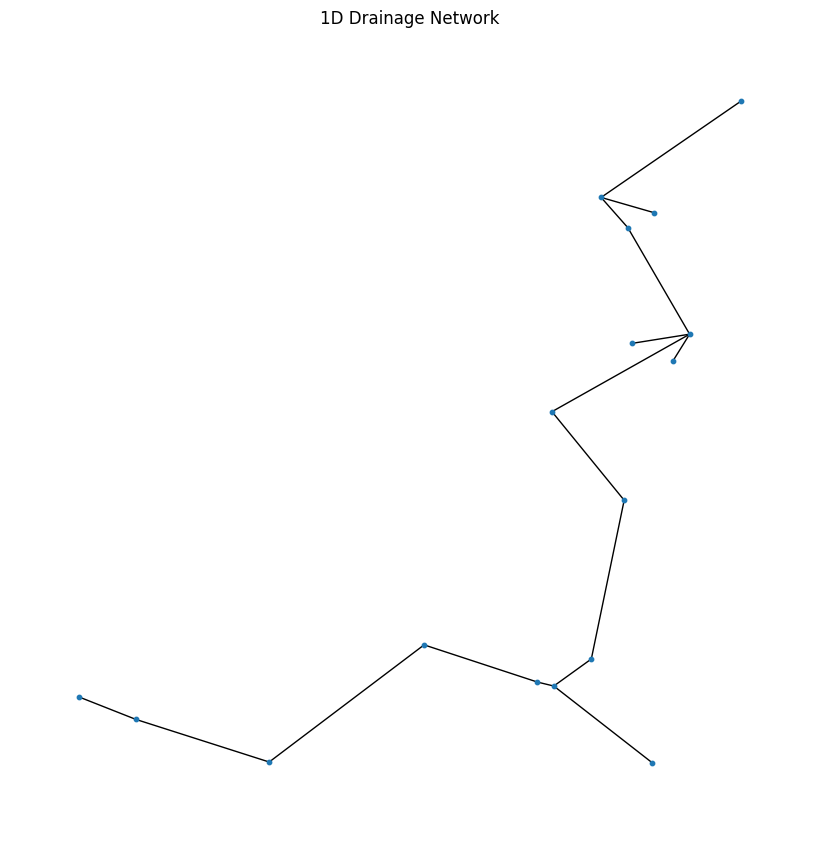

In [73]:
import matplotlib.pyplot as plt

pos = {
    n: (G_1d.nodes[n]["x"], G_1d.nodes[n]["y"])
    for n in G_1d.nodes
}

plt.figure(figsize=(8, 8))
nx.draw(
    G_1d,
    pos,
    node_size=10,
    arrows=False
)
plt.title("1D Drainage Network")
plt.show()


### Visualizing the 2D surface mesh

In [74]:
nodes_2d = pd.read_csv("urban-flood-modelling/2d_nodes_static.csv")
edges_2d = pd.read_csv("urban-flood-modelling/2d_edge_index.csv")

G_2d = nx.Graph()

for idx, row in nodes_2d.iterrows():
    G_2d.add_node(
        idx,
        x=row["position_x"],
        y=row["position_y"]
    )

for _, row in edges_2d.iterrows():
    G_2d.add_edge(row["from_node"], row["to_node"])


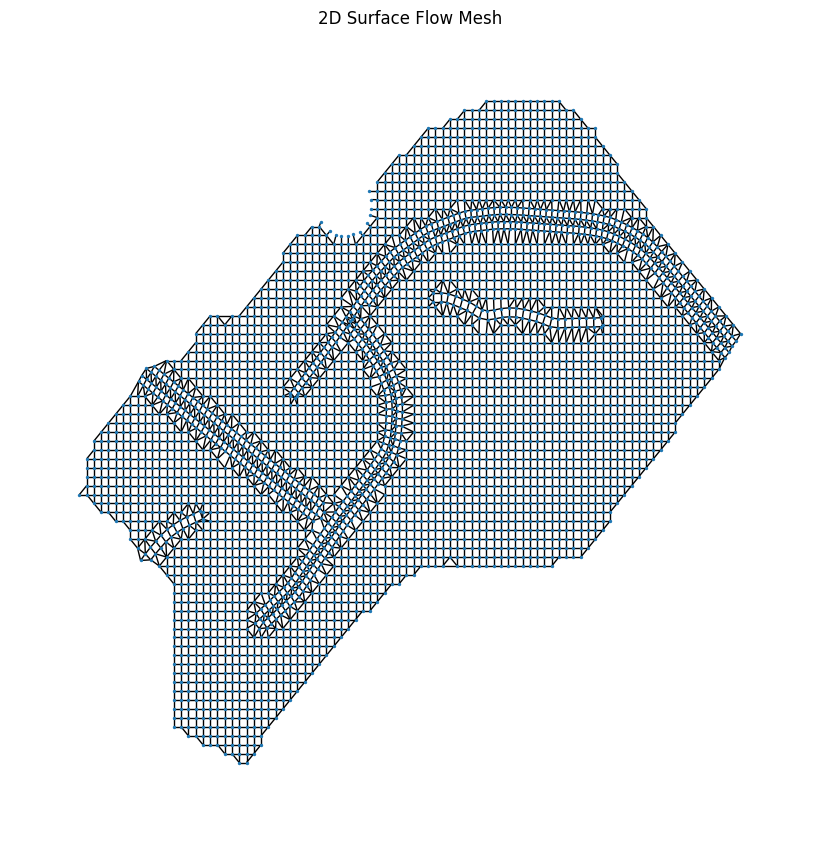

In [75]:
pos_2d = {
    n: (G_2d.nodes[n]["x"], G_2d.nodes[n]["y"])
    for n in G_2d.nodes
}

plt.figure(figsize=(8, 8))
nx.draw(G_2d, pos_2d, node_size=2)
plt.title("2D Surface Flow Mesh")
plt.show()


### Visualizing 1D–2D coupling

In [76]:
connections = pd.read_csv("urban-flood-modelling/1d2d_connections.csv")
connections.head()

,connection_idx,node_1d,node_2d
0,0,0,503
1,1,13,3669
2,2,12,3588
3,3,3,3595
4,4,4,3600


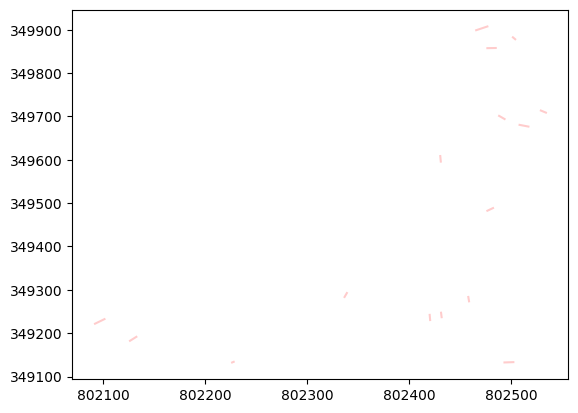

In [77]:
for _, row in connections.iterrows():
    x = [
        nodes_1d.loc[row["node_1d"], "position_x"],
        nodes_2d.loc[row["node_2d"], "position_x"]
    ]
    y = [
        nodes_1d.loc[row["node_1d"], "position_y"],
        nodes_2d.loc[row["node_2d"], "position_y"]
    ]
    plt.plot(x, y, color="red", alpha=0.2)


### Adding dynamics (water level coloring)

Example: color nodes by water level at timestep t=50.

In [78]:
dyn_1d = pd.read_csv("urban-flood-modelling/1d_nodes_dynamic_all.csv")
dyn_1d.head()

,timestep,node_idx,water_level,inlet_flow
0,0,0,294.87430,0.000000
1,0,1,288.22095,0.000000
2,0,2,311.72510,3.189905
3,0,3,310.67368,1.829733
4,0,4,311.72390,0.000000


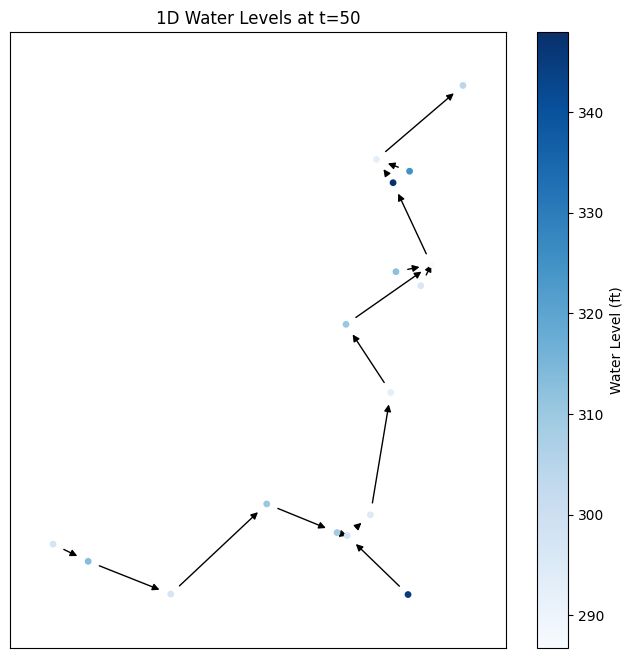

In [79]:
t = 50
slice_t = dyn_1d[dyn_1d["timestep"] == t]

water = slice_t["water_level"].values

plt.figure(figsize=(8,8))
# Capture the mappable returned by draw_networkx_nodes
nodes = nx.draw_networkx_nodes(
    G_1d,
    pos,
    node_color=water,
    cmap="Blues",
    node_size=15
)
# Draw edges separately
nx.draw_networkx_edges(G_1d, pos)

# Pass the mappable 'nodes' to colorbar
plt.colorbar(nodes, label="Water Level (ft)")
plt.title(f"1D Water Levels at t={t}")
plt.show()

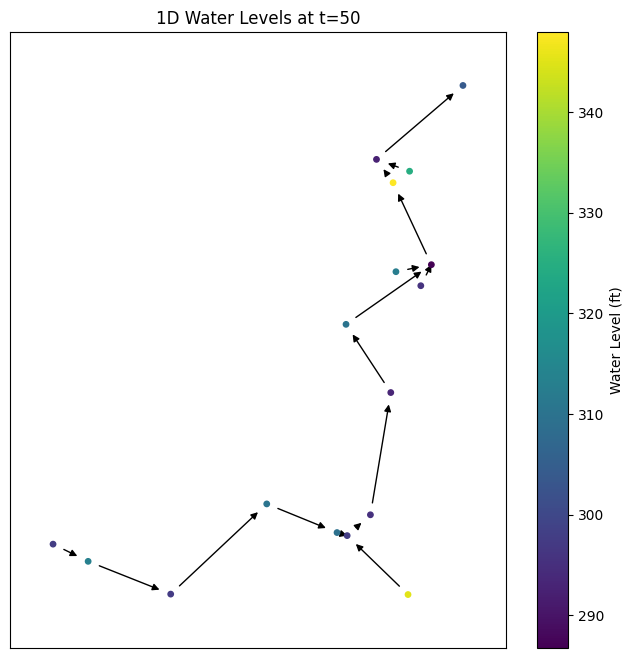

In [80]:
plt.figure(figsize=(8,8))

# Draw nodes and capture the output
nodes = nx.draw_networkx_nodes(
    G_1d, 
    pos, 
    node_size=15, 
    node_color=slice_t["water_level"],  # You need to pass the color data here
    cmap=plt.cm.viridis       # And specify a colormap
)

# Draw edges separately
nx.draw_networkx_edges(G_1d, pos)

# Now pass the 'nodes' object to colorbar
plt.colorbar(nodes, label="Water Level (ft)")
plt.title(f"1D Water Levels at t={t}")
plt.show()

### Implementing filled surface using triangulation

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation


In [82]:
nodes_2d = pd.read_csv("urban-flood-modelling/2d_nodes_static.csv")

x = nodes_2d["position_x"].values
y = nodes_2d["position_y"].values


In [83]:
nodes_2d.head()

,node_idx,position_x,position_y,area,roughness,min_elevation,elevation,aspect,curvature,flow_accumulation
0,0,803051.56,350382.44,825.63544,0.06,329.75012,331.09375,185.94380,0.000082,8.0
1,1,803076.56,350382.44,616.87900,0.06,329.84910,330.90625,182.54686,0.000036,1.0
2,2,803101.56,350382.44,611.14510,0.06,329.69390,330.56250,140.86070,0.000004,2.0
3,3,803126.56,350382.44,605.41113,0.06,329.28427,330.00000,89.00771,0.000022,1.0
4,4,803151.56,350382.44,599.67720,0.06,328.35257,328.81250,96.00465,0.000061,3.0


In [84]:
tri = Triangulation(x, y)


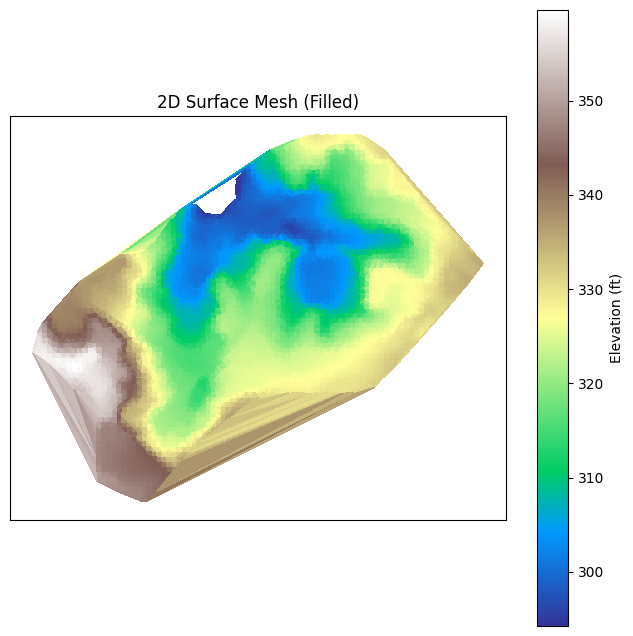

In [85]:
z = nodes_2d["min_elevation"].values  # or centroid elevation

plt.figure(figsize=(8, 8))
plt.tripcolor(
    tri,
    z,
    shading="flat",
    cmap="terrain"
)

plt.colorbar(label="Elevation (ft)")
plt.title("2D Surface Mesh (Filled)")
plt.gca().set_aspect("equal")
plt.xticks([])
plt.yticks([])
plt.show()


### Animate flood on the filled mesh

In [86]:
dyn_2d = pd.read_csv("urban-flood-modelling/2d_nodes_dynamic_all.csv")

[]

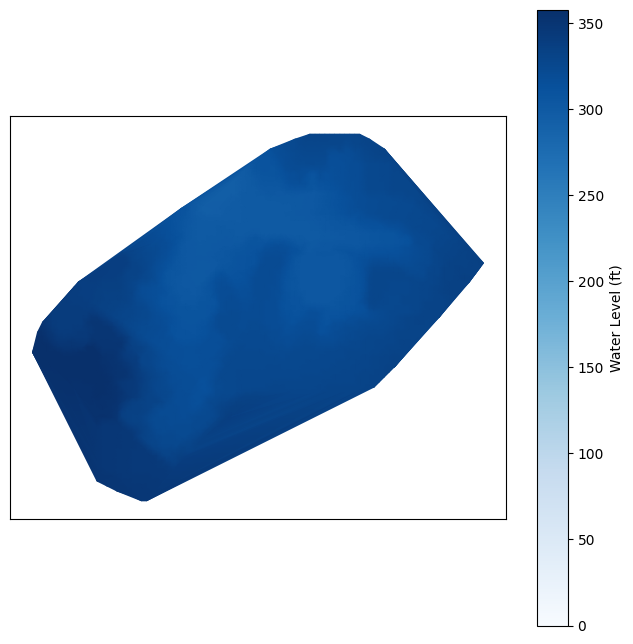

In [87]:
from matplotlib.animation import FuncAnimation

timesteps = sorted(dyn_2d["timestep"].unique())

fig, ax = plt.subplots(figsize=(8, 8))

t0 = timesteps[0]
z0 = dyn_2d[dyn_2d["timestep"] == t0]["water_level"].values

mesh = ax.tripcolor(
    tri,
    z0,
    shading="gouraud",  # Changed to gouraud for vertex-based coloring
    cmap="Blues",
    vmin=0,
    vmax=np.quantile(dyn_2d["water_level"], 0.99)
)

plt.colorbar(mesh, ax=ax, label="Water Level (ft)")
ax.set_aspect("equal")
ax.set_xticks([])
ax.set_yticks([])

In [88]:
def update(frame):
    t = timesteps[frame]
    z = dyn_2d[dyn_2d["timestep"] == t]["water_level"].values

    mesh.set_array(z)
    ax.set_title(f"Flood Surface | Timestep {t}")

    return mesh,


In [89]:
# Create the animation
ani = FuncAnimation(
    fig,
    update,
    frames=len(timesteps),
    interval=150,
    blit=False
)

# Try to save as MP4 (requires ffmpeg), fallback to GIF if not available
try:
    ani.save("filled_flood_surface.mp4", writer='ffmpeg', dpi=150)
    print("Animation saved as MP4: filled_flood_surface.mp4")
except Exception as e:
    print(f"MP4 save failed: {e}")
    print("Saving as GIF instead...")
    ani.save("filled_flood_surface.gif", writer='pillow', dpi=100, fps=10)
    print("Animation saved as GIF: filled_flood_surface.gif")

Animation saved as MP4: filled_flood_surface.mp4
